In [1]:
import mesa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import networkx as nx 



sns.set(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [83]:
class userAgent(mesa.Agent):
    
    def __init__( self, unique_id, model, update_method,  d = 1, m = 0.5):
        
        super().__init__(unique_id, model)

        self.opinion = random.uniform(0, 1) # initial opinion
        
        self.update_method = update_method
        
        # for deffaunt model
        self.d = d
        self.m = m 

        # for replicated model
        self.tendency_to_share = random.uniform(0, 1)
        self.peer_trust = random.uniform(0, 1)
        
        temp = random.uniform(0, 1)
        if temp < 1.0/3.0:
            self.risk_sensitivity = 0 # low risk sensitivity
        else:
            temp2 = random.uniform(0, 1)
            if temp2 < 0.5:
                self.risk_sensitivity = 2 # high risk sensitivity
            else:
                self.risk_sensitivity = 1 # medium risk sensitivity

    
    '''
    This function is for simple opinion update for Deffuant model
    '''
    def update_op_Deffuant(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        
        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))

            if abs(self.opinion - other_agent.opinion) < self.d:
                saved_opinion = self.opinion
                self.opinion = self.opinion + self.m * (other_agent.opinion - self.opinion)
                other_agent.opinion = other_agent.opinion + self.m * (saved_opinion - other_agent.opinion)
        

    '''
    This function is for simple opinion update process using only peer trust
    ''' 
    def update_op_P(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)
            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)


    
    '''
    This function is for opinion update process using peer trust - risk sensitivity 
    ''' 
    def update_op_P_and_R(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

            if self.risk_sensitivity == 0:
                self.opinion = self.opinion / 2.0
            elif self.risk_sensitivity == 2:
                self.opinion = (1.0 + self.opinion) / 2.0

            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

            if other_agent.risk_sensitivity == 0:
                other_agent.opinion = other_agent.opinion / 2.0
            elif other_agent.risk_sensitivity == 2:
                other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
                
         
    '''
    This function is for opinion update process using risk sensitivity then peer trust
    ''' 
    def update_op_R_then_P(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion

            if self.risk_sensitivity == 0:
                self.opinion = self.opinion / 2.0
            elif self.risk_sensitivity == 2:
                self.opinion = (1.0 + self.opinion) / 2.0

            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

            if other_agent.risk_sensitivity == 0:
                other_agent.opinion = other_agent.opinion / 2.0
            elif other_agent.risk_sensitivity == 2:
                other_agent.opinion = (1.0 + other_agent.opinion) / 2.0

            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

    
    
    '''
    This function is for opinion update process using (peer trust - tendency to share)
    '''
    def update_op_P_and_B(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion

            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                
                
    '''
    This function is for opinion update process using all agent varibales 
    (peer trust - risk sensitivity - tendency to share)
    '''
    def update_op_all(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion

            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                if self.risk_sensitivity == 0:
                    self.opinion = self.opinion / 2.0
                elif self.risk_sensitivity == 2:
                    self.opinion = (1.0 + self.opinion) / 2.0


            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                if other_agent.risk_sensitivity == 0:
                    other_agent.opinion = other_agent.opinion / 2.0
                elif other_agent.risk_sensitivity == 2:
                    other_agent.opinion = (1.0 + other_agent.opinion) / 2.0

            
    def step(self):
        
        if self.update_method == "update_op_Deffuant":    
            self.update_op_Deffuant() ## deffaunt model
        
        elif self.update_method == "update_op_P":
            self.update_op_P() ## only P

        elif self.update_method == "update_op_P_and_R":
            self.update_op_P_and_R() ## P then R

        elif self.update_method == "update_op_R_then_P":
            self.update_op_R_then_P() ## R then P 

        elif self.update_method == "update_op_P_and_B":
            self.update_op_P_and_B() ## P and B

        elif self.update_method == "update_op_all":
            self.update_op_all() ## P then R + d
        
        
#####################################################


def opinion_avg(model):
    return sum(a.opinion for a in model.grid.get_all_cell_contents())/model.num_agents

def tendency_to_share_avg(model):
    return sum(a.tendency_to_share for a in model.grid.get_all_cell_contents())/model.num_agents

def risk_avg(model):
    return sum(a.risk_sensitivity for a in model.grid.get_all_cell_contents())/model.num_agents

def peer_trust_avg(model):
    return sum(a.peer_trust for a in model.grid.get_all_cell_contents())/model.num_agents

#####################################################

class opinionsModel(mesa.Model):
    
    def __init__(self, N, update_method):
      
        self.num_agents = N
        
        self.update_method = update_method

        self.G = nx.complete_graph(n = self.num_agents)
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "op_avg": opinion_avg,
                "risk_avg" : risk_avg,
                "tendency_to_share_avg" : tendency_to_share_avg, 
                "peer_trust_avg" : peer_trust_avg,
            },
            agent_reporters = {
                "opinion" : "opinion", 
                "risk_sensitivity" : "risk_sensitivity",
                "tendency_to_share" : "tendency_to_share",
                "peer_trust" : "peer_trust",
            }
        )

        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)

        for i, node in enumerate(self.G.nodes()):           
            a = userAgent(i, self , self.update_method)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
           
        self.running = True
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        

## Experiments settings:

In [3]:
population = 500
simulation_duration = 100 

batch_run_iterations = 100

results_folder = "Replicated_model_results"

## baseline: Deffaunt model

In [4]:
#deffaunt
model = opinionsModel(N = population , update_method = "update_op_Deffuant")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [5]:
# save the results 
agents_data.to_csv(results_folder+"/basline_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/basline_model_data.csv", index=False)

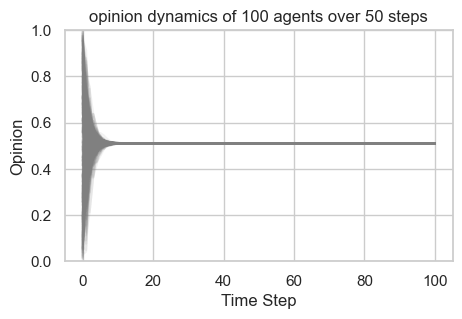

In [6]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

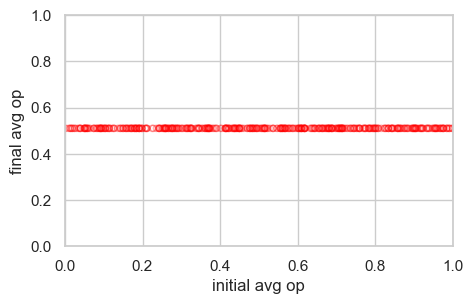

In [7]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == 50")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [8]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [9]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## batch run

In [10]:
# params = {
#     "N": population,
#     "update_method" : "update_op_Deffuant",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = simulation_duration,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [11]:
# results_df = pd.DataFrame(results)

In [12]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")

# plt.show()

In [13]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()


# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

## exp1. The impcat of peer trust

In [85]:
model = opinionsModel(N = population, update_method = "update_op_P")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [88]:
# save the results 
agents_data.to_csv(results_folder+"/exp1_p_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/exp1_p_model_data.csv", index=False)

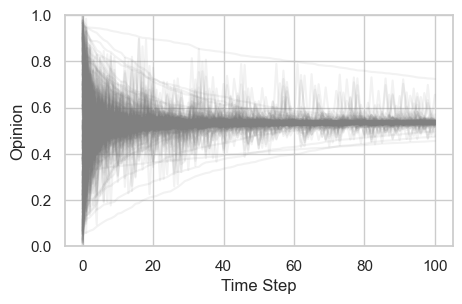

In [86]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
# plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

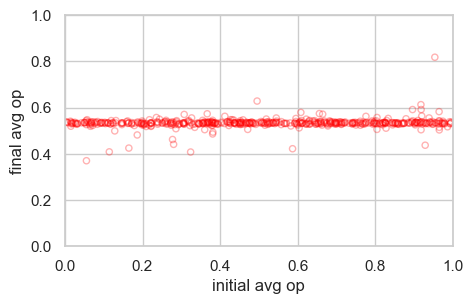

In [87]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == 50")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [18]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [19]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## batch run

In [20]:
# params = {
#     "N": population,
#     "update_method" : "update_op_P",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = sim,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [21]:
# results_df = pd.DataFrame(results)

In [22]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")
# plt.ylim(0,1)

# plt.show()

In [23]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()


# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

In [24]:
# initial_op = results_df.groupby('iteration').first().reset_index()
# final_op = results_df.groupby('iteration').last().reset_index()

# x = list(initial_op['op_avg'])
# y = list(final_op['op_avg'])

# plt.scatter(x, y, marker='o', s=10)

# # plt.title("Sumilation duartion and Avg Opinion")
# plt.xlabel('initial avg op')
# plt.ylabel('final avg op')
# # plt.xlim(0,1)
# # plt.ylim(0,1)


# plt.show()

## exp2. The impact of Risk Senitivity

In [25]:
model = opinionsModel(N = population, update_method = "update_op_P_and_R")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [26]:
# save the results 
agents_data.to_csv(results_folder+"/exp2_p_r_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/exp2_p_r_model_data.csv", index=False)

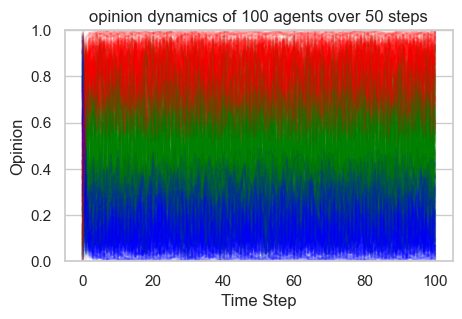

In [27]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)
    
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

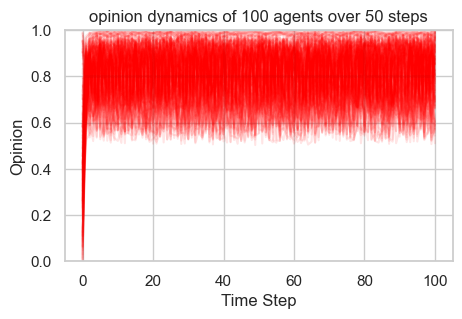

In [28]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

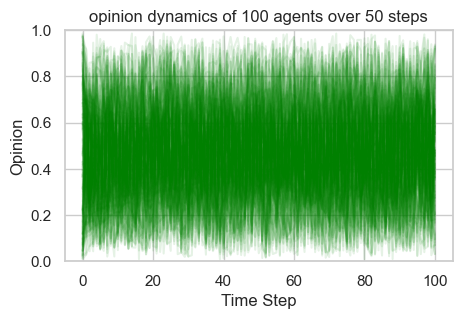

In [29]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

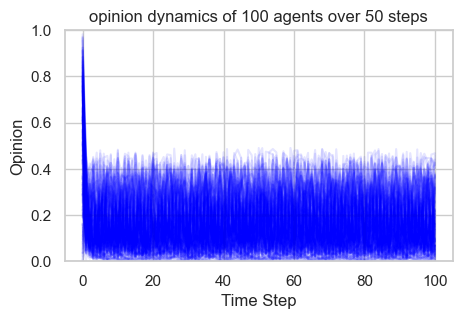

In [30]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

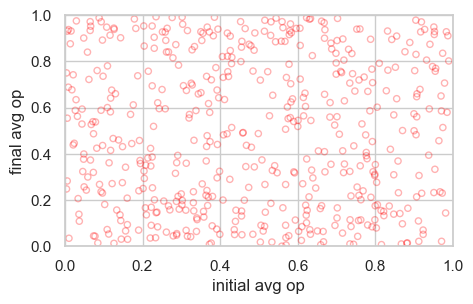

In [31]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == 50")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [32]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [33]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## Batch run

In [34]:
# params = {
#     "N": population,
#     "update_method": "update_op_P_and_R",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = simulation_duration,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [35]:
# results_df = pd.DataFrame(results)

In [36]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")

# plt.ylim(0,1)
# plt.show()

In [37]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

## exp3. The impact of Risk Senitivity as a first step

In [38]:
model = opinionsModel(N = population, update_method = "update_op_R_then_P")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [39]:
# save the results 
agents_data.to_csv(results_folder+"/exp3_r_p_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/exp3_r_p_model_data.csv", index=False)

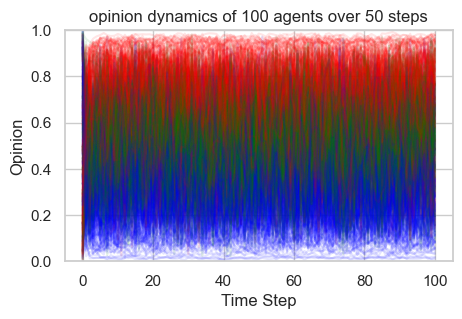

In [40]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)
    
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

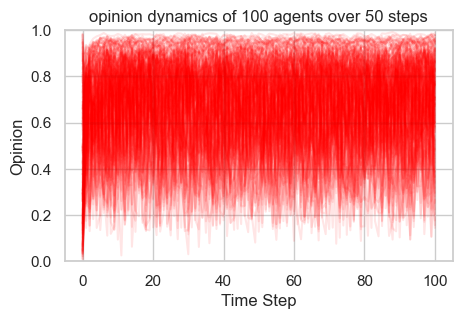

In [41]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

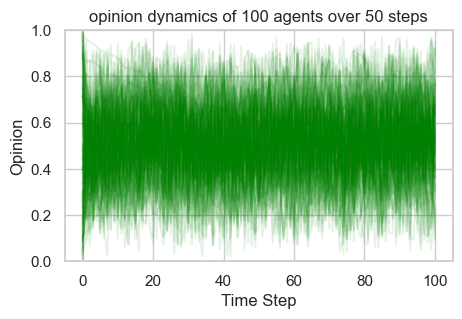

In [42]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

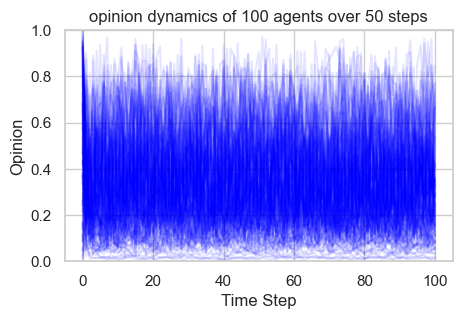

In [43]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

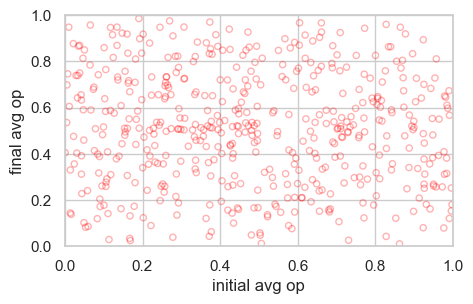

In [44]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == 50")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [45]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [46]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## Batch run

In [47]:
# params = {
#     "N": population,
#     "update_method": "update_op_P_and_R",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = simulation_duration,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [48]:
# results_df = pd.DataFrame(results)

In [49]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")

# plt.ylim(0,1)
# plt.show()

In [50]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

## exp 4. Impact of Tendency to share

In [51]:
model = opinionsModel(N = population , update_method = "update_op_P_and_B")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [52]:
# save the results 
agents_data.to_csv(results_folder+"/exp4_p_b_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/exp4_p_b_model_data.csv", index=False)

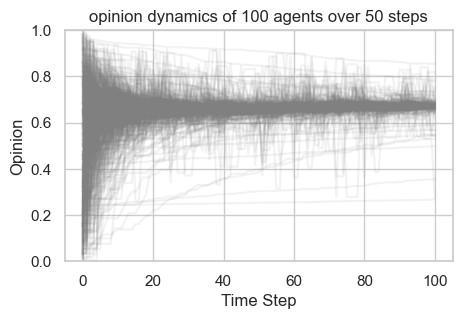

In [53]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

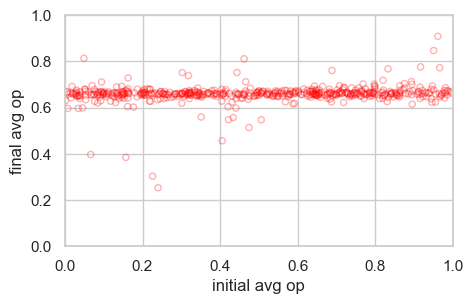

In [54]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == 50")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [55]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [56]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## batch run

In [57]:
# params = {
#     "N": population,
#     "update_method" : "update_op_P_and_B",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = simulation_duration,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [58]:
# results_df = pd.DataFrame(results)

In [59]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")
# plt.ylim(0,1)

# plt.show()

In [60]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()


# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

## exp 5. Impact of all

In [61]:
model = opinionsModel(N = population , update_method = "update_op_all")

num_steps = simulation_duration 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [62]:
# save the results 
agents_data.to_csv(results_folder+"/exp5_all_agent_data.csv", index=True)
model_data.to_csv(results_folder+"/exp5_all_model_data.csv", index=False)

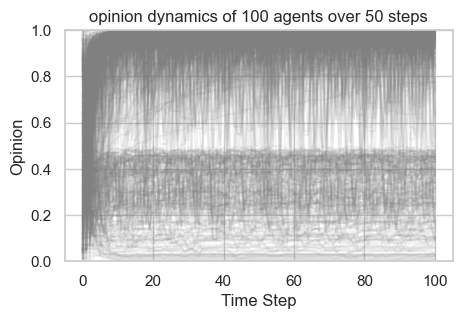

In [63]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

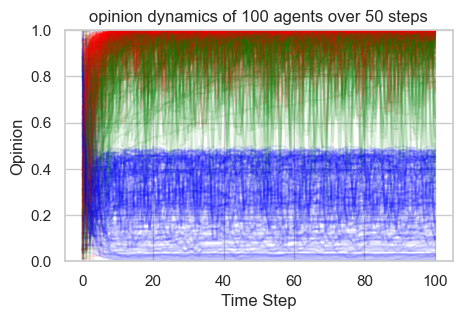

In [64]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)
    
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

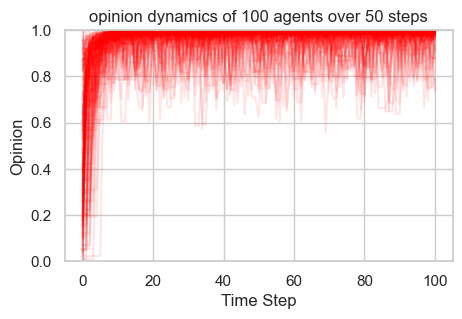

In [65]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

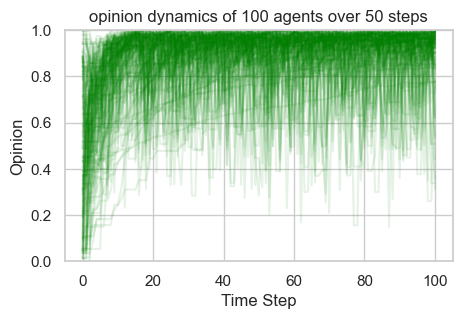

In [66]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

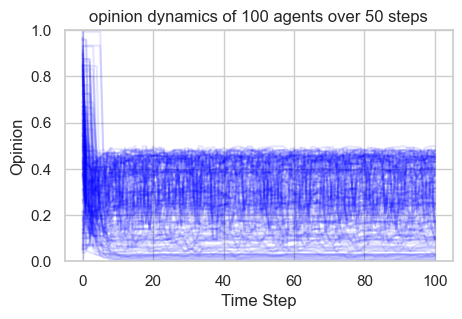

In [67]:
plt.figure(figsize=(5,  3))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.title("opinion dynamics of 100 agents over 50 steps")
plt.show()

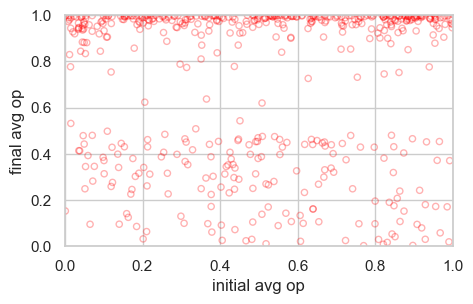

In [68]:
initial_op = list(agents_data.query("Step == 0")['opinion'])
final_op = list(agents_data.query("Step == @simulation_duration")['opinion'])

# x = initial_op
# y = final_op

plt.figure(figsize=(5,  3))
plt.scatter(x = initial_op, y = final_op, marker='o', s=20, alpha = 0.3, facecolor='none', edgecolor="red")

# plt.title("Sumilation duartion and Avg Opinion")
plt.xlabel('initial avg op')
plt.ylabel('final avg op')
plt.xlim(0,1)
plt.ylim(0,1)


plt.show()

In [69]:
# plt.figure(figsize=(5,  3))

# sns.lineplot(x="Step", y="opinion", data=agents_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Opinion")
# plt.title("opinion average over 50 steps")
# plt.show()

In [70]:
# plt.figure(figsize=(5,  3))

# variance_data = agents_data.groupby("Step")["opinion"].var().reset_index()

# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions")
# plt.show()

## batch run

In [71]:
# params = {
#     "N": population,
#     "update_method" : "update_op_P_and_B",
# }

# results = mesa.batch_run(
#     opinionsModel,
#     parameters = params,
#     iterations = batch_run_iterations,  # Number of model runs per parameter combination
#     max_steps = simulation_duration,  # Maximum number of steps per model run
#     number_processes = 1,
#     data_collection_period = 1,
#     display_progress = True,
# )

In [72]:
# results_df = pd.DataFrame(results)

In [73]:
# new_df = pd.DataFrame(results_df.groupby(['Step'])['op_avg'].mean())

# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="op_avg", data=new_df)

# plt.xlabel("Time Step")
# plt.ylabel("Opinions Average")
# # plt.legend(title="Institution Information")
# plt.title("Opinion Avg of 100 agents per time step - 100 iterations")
# plt.ylim(0,1)

# plt.show()

In [74]:
# variance_data = results_df.groupby("Step")["opinion"].var().reset_index()


# plt.figure(figsize=(5,  3))
# sns.lineplot(x="Step", y="opinion", data=variance_data)

# plt.ylim(0,1)
# plt.xlabel("Time Step")
# plt.ylabel("Variance")
# plt.title("variance in opinions - 100 iterations")
# plt.show()

## Batch run

In [84]:
params = {
    "N": population,
    "update_method" : [ "update_op_Deffuant", 
                        "update_op_P",
                        "update_op_P_and_R",
                        "update_op_R_then_P",
                        "update_op_P_and_B",
                        "update_op_all"
                      ],
}

results = mesa.batch_run(
    opinionsModel,
    parameters = params,
    
    iterations = batch_run_iterations,  # Number of model runs per parameter combination
    max_steps = simulation_duration,  # Maximum number of steps per model run

#     iterations = 5, # for testing
#     max_steps = 10, # for testing
  
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True,
)

100%|█████████████████████████████████████████| 600/600 [3:51:34<00:00, 23.16s/it]


In [89]:
results_df = pd.DataFrame(results)

In [90]:
results_df.to_csv(results_folder+"/batch_run_500_agents.csv", index=False)

In [79]:
results_df.head()

# because I have 6 methods I want to iterate over, each iteration will include 6 rounds 
# (one round for running each method)

,RunId,iteration,Step,N,update_method,op_avg,risk_avg,tendency_to_share_avg,peer_trust_avg
0,0,0,0,3,update_op_Deffuant,0.352673,1.0,0.755381,0.319199
1,0,0,1,3,update_op_Deffuant,0.352673,1.0,0.755381,0.319199
2,0,0,2,3,update_op_Deffuant,0.352673,1.0,0.755381,0.319199
3,0,0,3,3,update_op_Deffuant,0.352673,1.0,0.755381,0.319199
4,0,0,4,3,update_op_Deffuant,0.352673,1.0,0.755381,0.319199


In [80]:
results_df.shape

(330, 9)

In [81]:
results_df.query('iteration == 1').shape

(66, 9)